# Preliminary
* Import libraries
* Load data
* Train BlackBox model

In [1]:
import numpy as np
import pandas as pd
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
import scipy as sp

In [3]:
from itertools import combinations, islice

In [4]:
from datetime import datetime

In [5]:
bank_ds = pd.read_csv(os.path.join(DATASETS_DIR, 'bank.csv'), sep=';')
print(bank_ds.shape)
bank_ds.head()

(4521, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [6]:
y_feat = 'y'
s = bank_ds.drop(y_feat,1).dtypes
cat_feats = list(s[s==np.dtype('O')].index)
real_feats = list(s.drop(cat_feats).index)

X_train, X_test, y_train, y_test = train_test_split(bank_ds[cat_feats+real_feats], bank_ds[y_feat].apply(lambda x: {'no':0,'yes':1}[x]), random_state=42)
print('train size', len(X_train))
print('test size', len(X_test))


train_pool = cb.Pool(X_train, y_train, cat_features=cat_feats)
test_pool = cb.Pool(X_test, y_test, cat_features=cat_feats)
bb = cb.CatBoostClassifier()
bb.fit(train_pool, verbose=False, plot=False)

train_preds, test_preds = bb.predict(train_pool), bb.predict(test_pool)
train_preds_proba, test_preds_proba = bb.predict_proba(train_pool)[:,1], bb.predict_proba(test_pool)[:,1]
metrics_ds = []
for m in [accuracy_score, precision_score, recall_score]:
    res = {'train':m(y_train, train_preds), 'test':m(y_test, test_preds), 'metrics':m.__name__}
    metrics_ds.append(res)
metrics_ds.append({'train':y_train.mean(), 'test':y_test.mean(), 'metrics':'y_mean'})
metrics_ds = pd.DataFrame(metrics_ds).reindex(columns=['metrics','train','test'])
metrics_ds

train size 3390
test size 1131


,metrics,train,test
0,accuracy_score,0.938053,0.896552
1,precision_score,0.860465,0.550000
2,recall_score,0.560606,0.352000
3,y_mean,0.116814,0.110522


Calculate features influences to the prediction

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [8]:
sv_ds = pd.DataFrame(bb.get_feature_importance(data=test_pool,type='ShapValues'), columns=list(test_pool.get_feature_names())+['bias'])
bias = sv_ds['bias'][0]
sv_ds = sv_ds.drop('bias',1)
med = np.median(sv_ds.values.flatten())
print(f'adding {med*sv_ds.shape[1]} to bias')
bias += med*sv_ds.shape[1]
sv_ds -= med
print(sv_ds.shape)

adding -0.04683946991419995 to bias
(1131, 16)


In [9]:
(test_preds_proba-sigmoid(sv_ds.sum(1)+bias)).abs().sum()

2.5272346064822426e-13

# Build the context

I.e. sigmoid(Sum of shap values) for every row is the prediction of the model

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


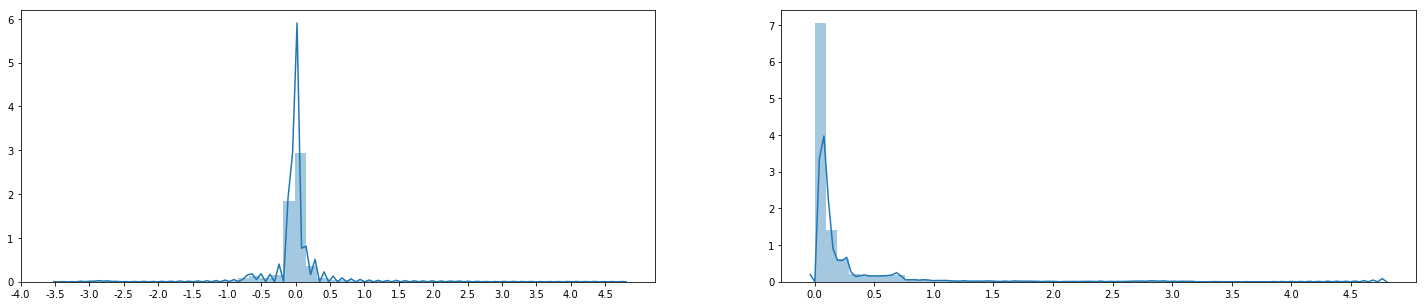

In [10]:
plt.figure(figsize=(25,5))
plt.subplot(121)
sns.distplot(sv_ds.values.flatten())
xticks = np.arange(-4,5,0.5)
plt.xticks(xticks, xticks.round(1))

plt.subplot(122)
sns.distplot(sv_ds.abs().values.flatten())
xticks = np.arange(0,5,0.5)
plt.xticks(xticks, xticks.round(1))

plt.show()

Not shure about the perfect way to compute percentiles. But it will do for the start

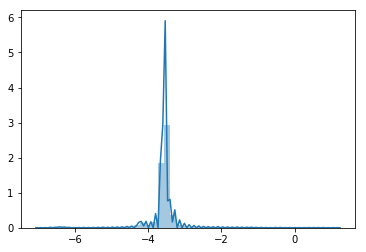

In [11]:
sns.distplot(sv_ds.values.flatten()+bias)

In [12]:
percs = np.percentile(sv_ds.values.flatten(), [25,50,75]).round(4)
percs

array([-0.0688,  0.    ,  0.047 ])

Build the context

In [13]:
context_ds = pd.DataFrame()
for f in sv_ds.columns:
    context_ds[f+'_neg_b'] = (sv_ds[f]<=percs[0]).astype(bool)
    context_ds[f+'_neg_s'] = ((sv_ds[f]>percs[0])&(sv_ds[f]<=percs[1])).astype(bool)
    context_ds[f+'_pos_s'] = ((sv_ds[f]>percs[1])&(sv_ds[f]<=percs[2])).astype(bool)
    context_ds[f+'_pos_b'] = (sv_ds[f]>percs[2]).astype(bool)
print(context_ds.shape)

(1131, 64)


Delete duplicated rows and columns

In [14]:
context_ds_small = context_ds.drop_duplicates()
context_ds_small = context_ds_small.T.drop_duplicates().T
print(context_ds_small.shape)

context_ds_small.head()

(1093, 64)


,job_neg_b,job_neg_s,job_pos_s,job_pos_b,marital_neg_b,marital_neg_s,marital_pos_s,marital_pos_b,education_neg_b,education_neg_s,...,campaign_pos_s,campaign_pos_b,pdays_neg_b,pdays_neg_s,pdays_pos_s,pdays_pos_b,previous_neg_b,previous_neg_s,previous_pos_s,previous_pos_b
0,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
1,False,False,True,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True
2,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
3,False,True,False,False,False,True,False,False,False,True,...,False,False,False,True,False,False,False,True,False,False
4,False,True,False,False,False,False,False,True,False,False,...,True,False,False,False,True,False,False,True,False,False


# Functions to build the concepts

Comparison with Concepts library

In [15]:
import concepts

In [16]:
def get_extent(cur_attrs, cntx, attrs_dict=None):
    assert attrs_dict is None or len(attrs_dict)==cntx.shape[1], 'Attributes dict should cover all columns of the Context and vice versa'
    
    attr_idxs = list(cur_attrs) if type(cur_attrs)==tuple else [cur_attrs] if type(cur_attrs)!=list else cur_attrs
    attr_idxs = [attrs_dict[m] for m in attr_idxs] if attrs_dict is not None else attr_idxs
    
    ext = np.arange(cntx.shape[0])
    ext = list(ext[cntx[:,attr_idxs].sum(1)==len(attr_idxs)])
    return ext

In [17]:
def get_intent(cur_objs, cntx, objs_dict=None):
    assert objs_dict is None or len(objs_dict)==cntx.shape[0], 'Objects dict should cover all rows of the Context and vice versa'
    
    obj_idxs = list(cur_objs) if type(cur_objs)==tuple else [cur_objs] if type(cur_objs)!=list else cur_objs
    obj_idxs = [objs_dict[g] for g in obj_idxs] if objs_dict is not None else obj_idxs

    int_ = np.arange(cntx.shape[1])
    cntx = cntx[obj_idxs]
    int_ = list(int_[cntx.sum(0)==len(obj_idxs)])
    return int_

In [18]:
attrs_dict = {m:i for i,m in enumerate(context_ds_small.columns)}
objs_dict = {g:i for i,g in enumerate(context_ds_small.index)}
context_bin_matr = context_ds_small.values.astype(bool)

In [19]:
#idxs = context_bin.sample(100, random_state=42).index
idxs = context_ds_small.index
objects = list(idxs)
properties = list(context_ds_small.columns)
bools = list(context_ds_small.loc[idxs].fillna(False).astype(bool).itertuples(index=False, name=None))
c_ = concepts.Context(objects, properties, bools)

/home/egor/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/egor/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


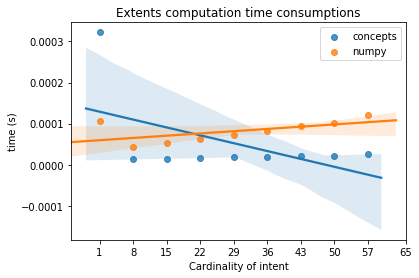

In [20]:
xaxis = list(np.linspace(1,len(context_ds_small.columns)+1, 10).astype(int))
y_conc = []
y_pand = []

for x in tqdm_notebook(xaxis):
    times_conc = []
    times_pand = []
    
    max_iter = 1000
    combs = list(islice(combinations(context_ds_small.columns, x),max_iter))
    if len(combs)<max_iter:
        combs = combs*max_iter
        combs = combs[:max_iter]
    for comb in tqdm_notebook(combs,  desc=f'x: {x}', leave=True, disable=True):    
        comb = list(comb)
        dt1 = datetime.now()
        c_.extension(comb)
        dt2 = datetime.now()
        times_conc.append((dt2-dt1).total_seconds())
        
        comb_int = [attrs_dict[m] for m in comb]
        
        dt1 = datetime.now()
        get_extent(comb_int, context_bin_matr)
        dt2 = datetime.now()
        times_pand.append((dt2-dt1).total_seconds())
        
        
    y_conc.append(np.mean(times_conc))
    y_pand.append(np.mean(times_pand))

sns.regplot(xaxis, y_conc, label='concepts')
sns.regplot(xaxis, y_pand, label='numpy')
plt.title('Extents computation time consumptions')
#sns.regplot(xaxis, y_pand_2, label='pands2')
plt.xticks(xaxis, xaxis)
plt.xlabel('Cardinality of intent')
plt.ylabel('time (s)')
plt.legend()
plt.show()

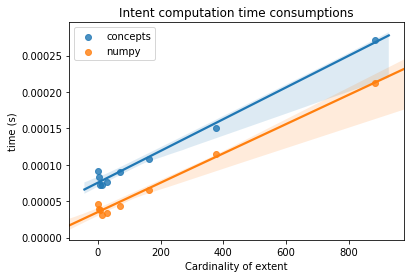

In [21]:
xaxis = list(np.logspace(0,np.log(len(context_ds_small.index)+1), 20).round().astype(int))
y_conc = []
y_pand = []

for x in tqdm_notebook(xaxis):
    times_conc = []
    times_pand = []
    
    max_iter = 1000
    combs = list(islice(combinations(context_ds_small.index, x),max_iter))
    if len(combs)<max_iter:
        combs = combs*max_iter
        combs = combs[:max_iter]
    for comb in tqdm_notebook(combs,  desc=f'x: {x}', leave=True, disable=True):    
        comb = list(comb)
        dt1 = datetime.now()
        c_.intension(comb)
        dt2 = datetime.now()
        times_conc.append((dt2-dt1).total_seconds())
        
        comb_int = [objs_dict[m] for m in comb]
        
        dt1 = datetime.now()
        get_intent(comb_int, context_bin_matr)
        dt2 = datetime.now()
        times_pand.append((dt2-dt1).total_seconds())
        
        
    y_conc.append(np.mean(times_conc))
    y_pand.append(np.mean(times_pand))

sns.regplot(xaxis, y_conc, label='concepts')
sns.regplot(xaxis, y_pand, label='numpy')
plt.title('Intent computation time consumptions')
#sns.regplot(xaxis, y_pand_2, label='pands2')
#plt.xticks(xaxis, xaxis)
plt.xlabel('Cardinality of extent')
plt.ylabel('time (s)')
plt.legend()
plt.show()

In [22]:
def close_by_one(cntx, max_iters_num=None, max_num_attrs=None, min_num_objs=None):
    #is_transposed = False
    #if cntx.shape[0]<cntx.shape[1]:
    #    cntx = cntx.T
    #    is_transposed = True
        
    combs_to_check = [[]]#[[i] for i in range(cntx.shape[1])]
    concepts = set()
    if max_num_attrs is not None and min_num_objs is not None:
        tot = min(sum([sp.misc.comb(N=cntx.shape[1],k=x) for x in range(0,max_num_attrs+1)]), sum([sp.misc.comb(N=cntx.shape[1],k=x) for x in range(0,min_num_objs+1)]))
        t = tqdm_notebook(total=tot)
    elif max_num_attrs is not None:
        t = tqdm_notebook(total=sum([sp.misc.comb(N=cntx.shape[1],k=x) for x in range(0,max_num_attrs+1)]))
    elif min_num_objs is not None:
        t = tqdm_notebook(total=sum([sp.misc.comb(N=cntx.shape[1],k=x) for x in range(0,min_num_objs+1)]))
    else:
        t = tqdm_notebook(total=len(combs_to_check))
    #t = tqdm_notebook(total=2**cntx.shape[1])
    
    i = 0 
    while len(combs_to_check)>0:
        i+=1
        if max_iters_num is not None and i>=max_iters_num:
            break
        comb = combs_to_check.pop(0)
        
        if max_num_attrs is not None and len(comb)>max_num_attrs:
            #t.update()
            continue
        #print(comb, len(comb), len(comb)>max_num_attributes)
        ext_ = get_extent(comb, cntx)
        if min_num_objs is not None and len(ext_)<=min_num_objs:
            continue
        int_ = get_intent(ext_, cntx)
        
        new_int_ = [x for x in int_ if x not in comb]
        
        if len(comb)>0 and any([x<comb[-1] for x in new_int_]):
            t.update()
            continue
        concepts.add((tuple(ext_), tuple(int_)))
        
        new_combs = [int_+[x] for x in range((int_[-1] if len(int_)>0 else -1)+1, cntx.shape[1])]
        combs_to_check = new_combs+combs_to_check
        t.update()
        if max_num_attrs is None or min_num_objs is not None:
            t.total += len(new_combs)
    
    #concepts = [(x[1],x[0]) for x in list(concepts)] if is_transposed else list(concepts)
    concepts = sorted(concepts, key=lambda x: len(x[1]))
    
    return concepts

In [23]:
def is_subconcept(a,b):
    """if a is subconcept of b, a<=b"""
    return all([g in b[0] for g in a[0]]) and all([m in a[1] for m in b[1]])

In [24]:
def get_lower_neighbours(concepts_set, use_tqdm=True):
    concepts_set = sorted(concepts_set, key=lambda x: len(x[0]))
    concepts_map = {k:i for i,k in enumerate(concepts_set)}
    concepts_map_inv = {v:k for k,v in concepts_map.items()}
    lower_neighbours = {concepts_map[concepts_set[0]]: set()}
    max_lowest_neighbours = {concepts_map[concepts_set[0]]: set()}
    
    for idx, concept in tqdm_notebook(enumerate(concepts_set[1:]), total=len(concepts_set)-1, disable=not use_tqdm):
        possible_neighbs = set([concepts_map[pn] for pn in concepts_set[:idx]])
        neighbs = set()
        ml_neighbs = set()
                    
        while len(possible_neighbs)>0:
            pn_idx = np.max(possible_neighbs)
            if type(pn_idx)==set:
                pn_idx = list(pn_idx)[0]
            possible_neighbs.remove(pn_idx)
            pn = concepts_map_inv[pn_idx]
            #print(pn_idx, pn)
            if pn_idx in neighbs:
                print('Hello there')
                continue
            if is_subconcept(pn, concept): 
                possible_neighbs = possible_neighbs-lower_neighbours[concepts_map[pn]]
                neighbs = neighbs|{pn_idx}|lower_neighbours[concepts_map[pn]]
                ml_neighbs.add(pn_idx)
                
            
        #for pn in tqdm_notebook(list(possible_neighbs),leave=True, disable=True):
        #    if pn[1] in neighbs:
        #        continue
        #    if is_subconcept(pn, concept):
        #        neighbs = neighbs|{concepts_map[pn[1]]}|set(lower_neighbours[concepts_map[pn[1]]])
        lower_neighbours[concepts_map[concept]] = neighbs
        max_lowest_neighbours[concepts_map[concept]] = ml_neighbs
    lower_neighbours = {concepts_map_inv[k]:tuple([concepts_map_inv[v_] for v_ in v]) for k,v in lower_neighbours.items()}
    max_lowest_neighbours = {concepts_map_inv[k]:tuple([concepts_map_inv[v_] for v_ in v]) for k,v in max_lowest_neighbours.items()}
    return lower_neighbours, max_lowest_neighbours

# Build concepts and their lattice

In [25]:
%%time
concepts_set = close_by_one(context_bin_matr, min_num_objs=int(context_ds_small.shape[0]*0.2))
print('Num of concepts: ',len(concepts_set))
# tool 779 ms and 878 concepts

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  from ipykernel import kernelapp as app



Num of concepts:  878
CPU times: user 806 ms, sys: 40 ms, total: 846 ms
Wall time: 838 ms


In [26]:
%%time
concepts_set_y_proba = [(c[0],c[1], np.median(test_preds_proba[context_ds_small.index][list(c[0])])) for c in concepts_set]
concepts_set_y_bin = [(c[0],c[1], np.mean(test_preds[context_ds_small.index][list(c[0])])) for c in concepts_set]

CPU times: user 153 ms, sys: 1.03 ms, total: 154 ms
Wall time: 154 ms


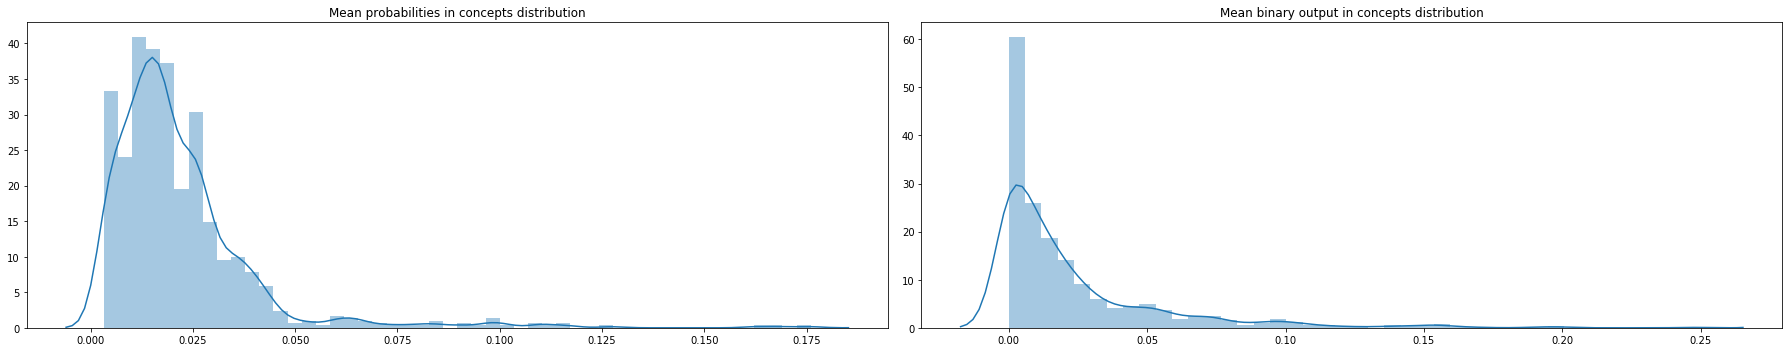

In [27]:
plt.figure(figsize=(25,5))
plt.subplot(121)
sns.distplot([c[2] for c in concepts_set_y_proba[:-1]])
plt.title('Mean probabilities in concepts distribution')

plt.subplot(122)
sns.distplot([c[2] for c in concepts_set_y_bin[:-1]])
plt.title('Mean binary output in concepts distribution')

plt.tight_layout()
plt.show()

In [28]:
ln, mln = get_lower_neighbours(concepts_set,)

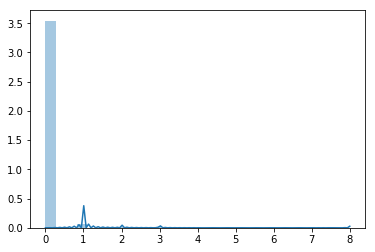

In [29]:
sns.distplot([len(ln[c])-len(mln[c]) for c in concepts_set])

In [30]:
sorted([(len(c[0]),[context_ds_small.columns[y] for y in c[1]], c[2]) for c in concepts_set_y_bin if c[2]>=0.1], key=lambda c: -c[2])

[(234,
  ['contact_pos_b', 'duration_pos_b', 'campaign_pos_s'],
  0.24786324786324787),
 (349, ['contact_pos_b', 'duration_pos_b'], 0.1977077363896848),
 (248, ['default_neg_s', 'duration_pos_b'], 0.1975806451612903),
 (346, ['duration_pos_b', 'campaign_pos_s'], 0.1907514450867052),
 (231,
  ['default_neg_s', 'duration_pos_b', 'previous_neg_s'],
  0.16883116883116883),
 (248, ['housing_pos_b', 'campaign_pos_s'], 0.16129032258064516),
 (327, ['month_pos_b'], 0.1559633027522936),
 (302, ['contact_pos_b', 'month_pos_b'], 0.15562913907284767),
 (219, ['job_neg_s', 'contact_pos_b', 'duration_pos_b'], 0.1552511415525114),
 (239,
  ['education_pos_s', 'contact_pos_b', 'duration_pos_b'],
  0.15481171548117154),
 (518, ['duration_pos_b'], 0.1525096525096525),
 (227, ['job_neg_s', 'duration_pos_b', 'campaign_pos_s'], 0.14977973568281938),
 (278,
  ['contact_pos_b', 'duration_pos_b', 'previous_neg_s'],
  0.1474820143884892),
 (282, ['education_pos_s', 'duration_pos_b'], 0.1453900709219858),
 (279

The question now is How to reduce amount of concepts. How to delete "unimportant" concepts